### Truncated copula MLE

In [2]:
# Load everything - Gamma
%matplotlib inline
from scipy.optimize import dual_annealing
import numpy as np
import scipy.stats as scs
from matplotlib import pyplot as plt
from sklearn.gaussian_process.kernels import Matern
from collections import Counter
from mpl_toolkits.basemap import Basemap
from geopy.geocoders import Nominatim
from tqdm import tqdm
from datetime import datetime
import itertools
from itertools import permutations
from scipy.spatial import distance_matrix
import matplotlib
import matplotlib.colors as mcolors
from sklearn import metrics
import pickle
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics.pairwise import rbf_kernel as rbf
from math import sqrt
from joblib import Parallel, delayed
import psutil
import math
import scipy
from scipy.sparse import csr_matrix
from scipy.sparse import csc_matrix
from scipy.sparse import coo_matrix
import scipy.sparse
import warnings
import networkx as nx
import multiprocessing
import pylab
#import scikit.sparse as cholmod


#from parallel.backends import BackendDummy as Backend
#backend = Backend()
#################
with open('inv_Us.txt','rb') as f:
    inv_us = pickle.load(f)

with open('did_rain_01.txt','rb') as f:
    did_rain_01 = pickle.load(f)

with open('g2_us.txt','rb') as f:
    g2_us = pickle.load(f)

with open('dist_mat.txt','rb') as f:
    dist_mat = pickle.load(f)

In [3]:
# Functions

# MC estimate - Correct and working

def mc_cdf(rvs,cov_matrix,ppf_us):
    '''
    rvs: [[set1], ... , [set m]] each set of length = #locations = n.
    cov_matrix: covariance matrix between the locations in question.
    ppf_us: [u1, ... , un] length = # locs.
    '''    
    # rvs are mean 0 already, but need different covariance
    cholesk_mat = np.linalg.cholesky(cov_matrix)
    normcov_vars = [np.asarray(cholesk_mat@rvs[i]) for i in range(len(rvs))]
    out = max(1e-13,np.sum([np.sum([normcov_vars[m][n]<ppf_us[n] for n in range(len(ppf_us))])==len(ppf_us) for m in range(len(normcov_vars))]))
    return out/len(rvs)       

# New cdf calculation - correct and working
def mvn_cdf(a,b,Sigma):
    m = len(a)
    # Reorder Sigma, a and b according to the length of interval (higher earlier)
    len_interval = np.zeros(m)
    for ind in range(m):
        if a[ind] == -np.inf:
            a[ind] = -100000
        if b[ind] == np.inf:
            b[ind] = 100000
        len_interval[ind] = b[ind] - a[ind]
    order_len_interval = [int(i[0]) for i in sorted(enumerate(len_interval), key=lambda x:x[1], reverse=True)]
    Sigma = Sigma[order_len_interval, :][:,order_len_interval]
    a = [a[x] for x in order_len_interval]
    b = [b[x] for x in order_len_interval]


    d = np.zeros(shape=(m,))
    e = np.ones(shape=(m,))
    f = np.zeros(shape=(m,))
    y = np.zeros(shape=(m,))
    # these can be changed for different precision levels
    epsilon = 1.e-5
    alpha = 2.5
    N_max = int(1e5)

    # Compute Cholesky decomposition of Sigma to produce lower trinagualr matrix
    C = np.linalg.cholesky(Sigma)

    #Sigma_sparse = sparse.csc_matrix(Sigma)
    #C_sparse = cholmod.cholesky(Sigma_sparse).L()
    #C = C_sparse

    Intsum, N, Varsum = 0, 0, 0

    if a[0] != -np.inf:
        d[0] = scs.norm.cdf(a[0]/C[0,0])
    if b[0] != np.inf:
        e[0] = scs.norm.cdf(b[0]/C[0,0])
    f[0] = np.log(e[0] - d[0])

    for ind_N in range(N_max):
        
        w = np.random.rand(m)
        for ind_m in range(1,m):
            y[ind_m-1] = scs.norm.ppf(d[ind_m-1]+w[ind_m-1]*(e[ind_m-1]-d[ind_m-1]))
            if a[ind_m] != -np.inf:
                d[ind_m] = scs.norm.cdf((a[ind_m]-sum(C[ind_m, :ind_m]*y[:ind_m]))/C[ind_m,ind_m])
            if b[ind_m] != np.inf:
                e[ind_m] = scs.norm.cdf((b[ind_m]-sum(C[ind_m, :ind_m]*y[:ind_m]))/C[ind_m,ind_m])
            f[ind_m] = np.log((e[ind_m] - d[ind_m])) + f[ind_m-1]
        N = N+1
        delta = (f[-1]-Intsum)/N
        Intsum = Intsum + delta
        Varsum = (N-2)*Varsum/N + pow(delta, 2)
        Error = alpha*np.sqrt(Varsum)
        if Error < epsilon:
            break

    return(Intsum)
# Truncated Gaussian copula class
class truncgauss():
    def __init__(self,L):
        '''
        Class to fit and work with a truncated Gaussian copula, using two functions.
        sim: simulated [0,1] values using this copula density.
        eval_nll: evaluate the negative log likelihood based on given data.
        To use the class, the dimension of the data is needed.
        n: dimension of data
        '''
        self.L=L
    
    def sim(self,theta,inv_us,draws,day_idx):
        '''
        Simulates m draws from the truncated gaussian copula conditional on parameters theta for the covariance kernel.
        '''
        # Generate mvn with Sigma, then truncate according to p_i
        n = len(self.L)
        cov_mat = rbf(self.L,gamma=theta)
        rvs = scs.multivariate_normal.rvs(np.zeros(n),cov_mat,size=draws)
        rvs_cov = [np.asarray(np.linalg.cholesky(cov_mat)@rvs[i]) for i in range(len(rvs))]

        return [[ scs.norm.cdf(max([rvs_cov[i][j],inv_us[day_idx][j]])) for j in range(n)] for i in range(draws)]

    def nll(self,theta,Invcdf_Us,truncation_pi,did_rain,len_locs,rvs):
        cov_mat = np.nan_to_num(rbf(self.L,gamma=theta),copy=False,nan=0)
        nll=0
        for day in tqdm(range(len(Invcdf_Us))): #eg [251,...,500]
            
            # numerator: joint pdf integrated over truncation - equivalent to elegant normal cdf in some cases. Check cases:
            if np.sum(did_rain[day])==len(did_rain[day]): #all wet, just normal pdf
                nll += scs.multivariate_normal.logpdf(x=Invcdf_Us[day],mean=np.zeros(len(Invcdf_Us[0])),cov=cov_mat)
            else: # some dry -> use elegant cdf
                #print('elegant'+str(np.sum(did_rain[day])))
                if np.sum(did_rain[day])==0: # all dry -> use normal cdf
                    nll += scs.multivariate_normal.logcdf(x=Invcdf_Us[day],mean=np.zeros(len(Invcdf_Us[0])),cov=cov_mat)

                else:
                    
                    # need to re-arrange the covariance matrix into 2*2 blocks based on censored/uncensored. 
                    r_rain,c_rain = [[i] for i in np.nonzero(did_rain[day])[0]],[i for i in np.nonzero(did_rain[day])[0]]
                    r_dry,c_dry = [[i] for i in range(len_locs) if i not in np.nonzero(did_rain[day])[0]],[i for i in range(len_locs) if i not in np.nonzero(did_rain[day])[0]]
                    
                    # create submatricies
                    submat11 = cov_mat[r_dry,c_dry]
                    submat12 = cov_mat[r_dry,c_rain]
                    submat21 = cov_mat[r_rain,c_dry]
                    submat22 = cov_mat[r_rain,c_rain]
                   
                    # compute and add the elegant cdf
                    if len(submat22)==1:
                        nll += scs.multivariate_normal.logcdf(x=[Invcdf_Us[day][k] for k in c_dry],mean=np.zeros(len(submat11)),cov=(submat11-submat12*np.linalg.inv(submat22)[0]*submat21))
                    else:
                        nll += scs.multivariate_normal.logcdf(x=[Invcdf_Us[day][k] for k in c_dry],mean=np.zeros(len(submat11)),cov=(submat11-submat12@np.linalg.inv(submat22)@submat21))
            
            # denominator: multiplication of marginals - pdf for positive rain, cdf for truncated
            for loc in range(len(Invcdf_Us[0])):
                if did_rain[day][loc]==1:# wet: add pdf(invcdf(u_i))
                    nll -= scs.norm.logpdf(Invcdf_Us[day][loc],loc=0,scale=1)
                else:# dry: add cdf(invcdf(pi))
                    nll -= np.log(truncation_pi[day][loc])
            
        return -nll

    def nll_mc(self,theta,Invcdf_Us,truncation_pi,did_rain,len_locs,rvs):
        cov_mat = np.nan_to_num(rbf(self.L,gamma=theta),copy=False,nan=0)
        nll=0
        for day in tqdm(range(len(Invcdf_Us))): #eg [251,...,500]
            
            # numerator: joint pdf integrated over truncation - equivalent to elegant normal cdf in some cases. Check cases:
            if np.sum(did_rain[day])==len(did_rain[day]): #all wet, just normal pdf
                nll += scs.multivariate_normal.logpdf(x=Invcdf_Us[day],mean=np.zeros(len(Invcdf_Us[0])),cov=cov_mat)
            else: # some dry -> use elegant cdf
                #print('elegant'+str(np.sum(did_rain[day])))
                if np.sum(did_rain[day])==0: # all dry -> use normal cdf
                    nll += scs.multivariate_normal.logcdf(x=Invcdf_Us[day],mean=np.zeros(len(Invcdf_Us[0])),cov=cov_mat)

                else:
                    
                    # need to re-arrange the covariance matrix into 2*2 blocks based on censored/uncensored. 
                    r_rain,c_rain = [[i] for i in np.nonzero(did_rain[day])[0]],[i for i in np.nonzero(did_rain[day])[0]]
                    r_dry,c_dry = [[i] for i in range(len_locs) if i not in np.nonzero(did_rain[day])[0]],[i for i in range(len_locs) if i not in np.nonzero(did_rain[day])[0]]
                    
                    # create submatricies
                    submat11 = cov_mat[r_dry,c_dry]
                    submat12 = cov_mat[r_dry,c_rain]
                    submat21 = cov_mat[r_rain,c_dry]
                    submat22 = cov_mat[r_rain,c_rain]
                    #### MC estimate part      ####

                    if len(submat22)!=1:
                        sub_cov = (submat11-submat12@np.linalg.inv(submat22)@submat21)#.reshape(len(c_dry),len(c_dry))
                    else: # submat22 is an integer, aka only one non-zero obs
                        sub_cov = (submat11-submat12*np.linalg.inv(submat22)[0]*submat21)#.reshape(len(c_dry),len(c_dry))
                    
                    # Do MC approximation to cdf
                    nll += np.log(mc_cdf([rvs[i][:len(c_dry)] for i in range(len(rvs))],sub_cov,[inv_us[day][k] for k in c_dry]))

                    #### MC estimate part - end ####


                    # compute and add the elegant cdf
                    #if len(submat22.todense())==1:
                    #    nll += scs.multivariate_normal.logcdf(x=[Invcdf_Us[day][k] for k in c_dry],mean=np.zeros(len(submat11.todense())),cov=(submat11-submat12*scipy.sparse.linalg.inv(submat22)[0]*submat21).todense())
                    #else:
                    #    nll += scs.multivariate_normal.logcdf(x=[Invcdf_Us[day][k] for k in c_dry],mean=np.zeros(len(submat11.todense())),cov=(submat11-submat12@scipy.sparse.linalg.inv(submat22)@submat21).todense())
            
            # denominator: multiplication of marginals - pdf for positive rain, cdf for truncated
            for loc in range(len(Invcdf_Us[0])):
                if did_rain[day][loc]==1:# wet: add pdf(invcdf(u_i))
                    nll -= scs.norm.logpdf(Invcdf_Us[day][loc],loc=0,scale=1)
                else:# dry: add cdf(invcdf(pi))
                    nll -= np.log(truncation_pi[day][loc])
            
        return -nll

    def nll_new(self,theta,Invcdf_Us,truncation_pi,did_rain,len_locs):
        cov_mat = np.nan_to_num(rbf(self.L,gamma=theta),copy=False,nan=0)
        nll=0
        for day in tqdm(range(len(Invcdf_Us))): #eg [251,...,500]
            
            # numerator: joint pdf integrated over truncation - equivalent to elegant normal cdf in some cases. Check cases:
            if np.sum(did_rain[day])==len(did_rain[day]): #all wet, just normal pdf
                nll += scs.multivariate_normal.logpdf(x=Invcdf_Us[day],mean=np.zeros(len(Invcdf_Us[0])),cov=cov_mat)
            else: # some dry -> use elegant cdf
                #print('elegant'+str(np.sum(did_rain[day])))
                if np.sum(did_rain[day])==0: # all dry -> use normal cdf
                    nll += scs.multivariate_normal.logcdf(x=Invcdf_Us[day],mean=np.zeros(len(Invcdf_Us[0])),cov=cov_mat)

                else:
                    
                    # need to re-arrange the covariance matrix into 2*2 blocks based on censored/uncensored. 
                    r_rain,c_rain = [[i] for i in np.nonzero(did_rain[day])[0]],[i for i in np.nonzero(did_rain[day])[0]]
                    r_dry,c_dry = [[i] for i in range(len_locs) if i not in np.nonzero(did_rain[day])[0]],[i for i in range(len_locs) if i not in np.nonzero(did_rain[day])[0]]
                    
                     # create submatricies
                    submat11 = cov_mat[r_dry,c_dry]
                    submat12 = cov_mat[r_dry,c_rain]
                    submat21 = cov_mat[r_rain,c_dry]
                    submat22 = cov_mat[r_rain,c_rain]
                    
                    #### New estimate part      ####

                    if len(submat22)!=1:
                        sub_cov = (submat11-submat12@np.linalg.inv(submat22)@submat21)#.reshape(len(c_dry),len(c_dry))
                    else: # submat22 is an integer, aka only one non-zero obs
                        sub_cov = (submat11-submat12*np.linalg.inv(submat22)[0]*submat21)#.reshape(len(c_dry),len(c_dry))
                    
                    # Do new approximation to cdf
                    test = [c_dry,[Invcdf_Us[day][k] for k in c_dry],sub_cov]
                    nll += mvn_cdf([-np.inf for i in range(len(c_dry))],[Invcdf_Us[day][k] for k in c_dry],sub_cov)                               

                    #### New estimate part - end ####


                    # compute and add the elegant cdf
                    #if len(submat22.todense())==1:
                    #    nll += scs.multivariate_normal.logcdf(x=[Invcdf_Us[day][k] for k in c_dry],mean=np.zeros(len(submat11.todense())),cov=(submat11-submat12*scipy.sparse.linalg.inv(submat22)[0]*submat21).todense())
                    #else:
                    #    nll += scs.multivariate_normal.logcdf(x=[Invcdf_Us[day][k] for k in c_dry],mean=np.zeros(len(submat11.todense())),cov=(submat11-submat12@scipy.sparse.linalg.inv(submat22)@submat21).todense())
            
            # denominator: multiplication of marginals - pdf for positive rain, cdf for truncated
            for loc in range(len(Invcdf_Us[0])):
                if did_rain[day][loc]==1:# wet: add pdf(invcdf(u_i))
                    nll -= scs.norm.logpdf(Invcdf_Us[day][loc],loc=0,scale=1)
                else:# dry: add cdf(invcdf(pi))
                    nll -= np.log(truncation_pi[day][loc])
            
        return -nll

#function for single nll eval   

def nll_sub_days(days_list,Invcdf_Us,truncation_pi,did_rain,len_locs,cov_mat):
    nll = 0
    for day in tqdm(days_list): #eg [251,...,500]
            
        # numerator: joint pdf integrated over truncation - equivalent to elegant normal cdf in some cases. Check cases:
        if np.sum(did_rain[day])==len(did_rain[day]): #all wet, just normal pdf
            nll += scs.multivariate_normal.logpdf(x=Invcdf_Us[day],mean=np.zeros(len(Invcdf_Us[0])),cov=cov_mat)
        else: # some dry -> use elegant cdf
            #print('elegant'+str(np.sum(did_rain[day])))
            if np.sum(did_rain[day])==0: # all dry -> use normal cdf
                nll += scs.multivariate_normal.logcdf(x=Invcdf_Us[day],mean=np.zeros(len(Invcdf_Us[0])),cov=cov_mat)

            else:
                
                # need to re-arrange the covariance matrix into 2*2 blocks based on censored/uncensored. 
                r_rain,c_rain = [[i] for i in np.nonzero(did_rain[day])[0]],[i for i in np.nonzero(did_rain[day])[0]]
                r_dry,c_dry = [[i] for i in range(len_locs) if i not in np.nonzero(did_rain[day])[0]],[i for i in range(len_locs) if i not in np.nonzero(did_rain[day])[0]]
                
                    # create submatricies
                submat11 = cov_mat[r_dry,c_dry]
                submat12 = cov_mat[r_dry,c_rain]
                submat21 = cov_mat[r_rain,c_dry]
                submat22 = cov_mat[r_rain,c_rain]
                
                #### New estimate part      ####

                if len(submat22)!=1:
                    sub_cov = (submat11-submat12@np.linalg.inv(submat22)@submat21)#.reshape(len(c_dry),len(c_dry))
                else: # submat22 is an integer, aka only one non-zero obs
                    sub_cov = (submat11-submat12*np.linalg.inv(submat22)[0]*submat21)#.reshape(len(c_dry),len(c_dry))
                
                # Do new approximation to cdf
                plt.matshow(sub_cov)
                print(sub_cov.min())
                print(sub_cov.max())
                test = [c_dry,[Invcdf_Us[day][k] for k in c_dry],sub_cov]
                print(mvn_cdf([-np.inf for i in range(len(c_dry))],[Invcdf_Us[day][k] for k in c_dry],sub_cov))
                nll += mvn_cdf([-np.inf for i in range(len(c_dry))],[Invcdf_Us[day][k] for k in c_dry],sub_cov)                             

                #### New estimate part - end ####


                # compute and add the elegant cdf
                #if len(submat22.todense())==1:
                #    nll += scs.multivariate_normal.logcdf(x=[Invcdf_Us[day][k] for k in c_dry],mean=np.zeros(len(submat11.todense())),cov=(submat11-submat12*scipy.sparse.linalg.inv(submat22)[0]*submat21).todense())
                #else:
                #    nll += scs.multivariate_normal.logcdf(x=[Invcdf_Us[day][k] for k in c_dry],mean=np.zeros(len(submat11.todense())),cov=(submat11-submat12@scipy.sparse.linalg.inv(submat22)@submat21).todense())
        
        # denominator: multiplication of marginals - pdf for positive rain, cdf for truncated
        for loc in range(len(Invcdf_Us[0])):
            if did_rain[day][loc]==1:# wet: add pdf(invcdf(u_i))
                nll -= scs.norm.logpdf(Invcdf_Us[day][loc],loc=0,scale=1)
            else:# dry: add cdf(invcdf(pi))
                nll -= np.log(truncation_pi[day][loc])
        
    return [-nll,test]


In [8]:
k = truncgauss(dist_mat).sim(1/(0.5*0.5*2),inv_us,4,day_idx=3)

In [10]:
 # heatmap over the uk of rain -> use gamma on the u's
 # show real observed hatmap over 

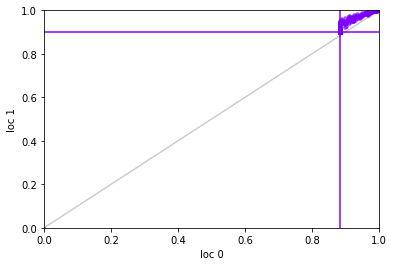

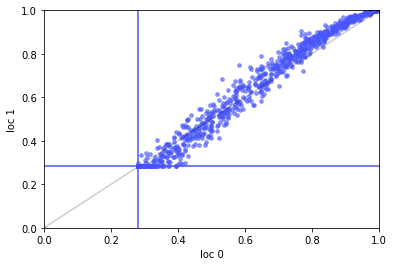

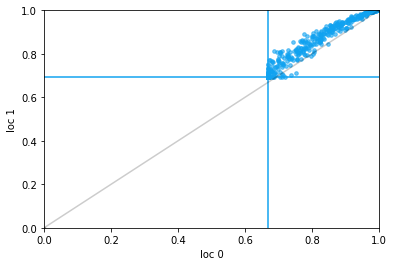

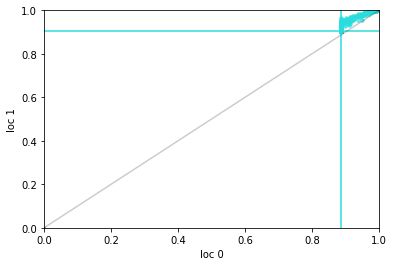

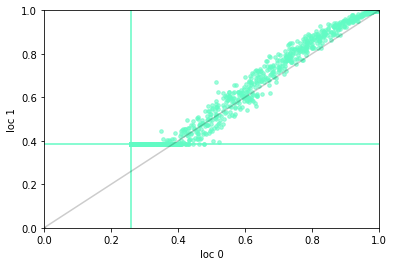

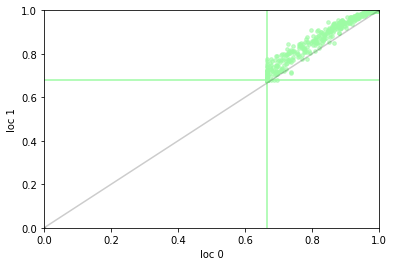

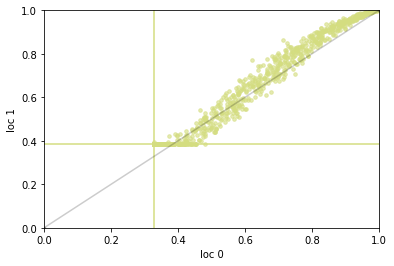

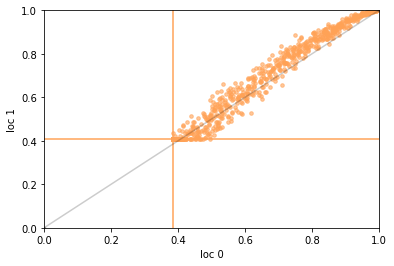

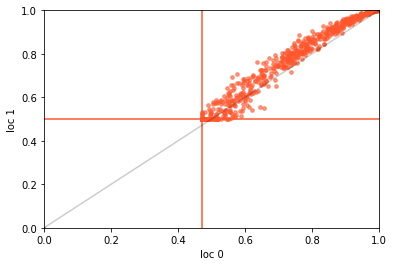

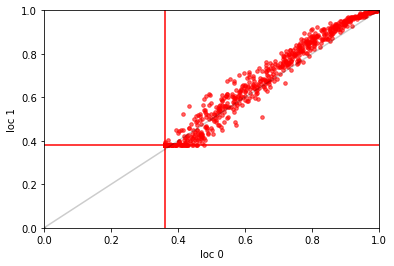

In [5]:
color = matplotlib.pyplot.cm.rainbow(np.linspace(0, 1, 10))

for d_idx,d in enumerate(range(10)):
    k = truncgauss(dist_mat[:2,:2]).sim(2.912,inv_us,1000,day_idx=d)
    plt.scatter([k[i][0] for i in range(len(k))],[k[i][1] for i in range(len(k))],alpha=0.6,s=13,color=color[d])
    plt.plot([g2_us[d][0],g2_us[d][0]],[0,1],color=color[d])
    plt.plot([0,1],[g2_us[d][1],g2_us[d][1]],color=color[d])
    plt.xlim((0,1))
    plt.ylim((0,1))
    plt.plot([0,1],[0,1],color='black',alpha=0.2,marker='.')
    plt.xlabel('loc 0')
    plt.ylabel('loc 1')
    plt.show()


In [3]:
# rvs for MC estimate
rand_vars = scs.multivariate_normal.rvs(np.zeros(len(dist_mat)),np.eye(len(dist_mat)),size=1000)
# length = size, each set is of length = #locs

In [4]:
# Covariance matrix
covariance_matrix = np.nan_to_num(rbf(dist_mat,gamma=1/(2*0.1*0.1)),copy=False,nan=0)

### use breaking down into blocks idea at the part with the cdf for dry days
Discarded

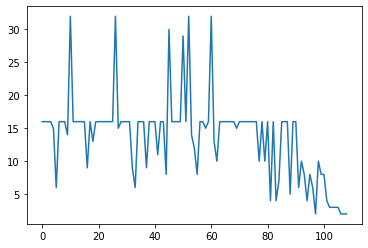

In [4]:
# This creates groups of indexes corresponding to correlated 'blocks' in the covariance/locations matrix
a = np.where(covariance_matrix[:300,:300]>0.4)
b = np.where([a[0]!=a[1]])
#c = np.nonzero(b)
c = [(a[0][i],a[1][i]) for i in b[1]]
pairs = list(set([tuple(sorted(c_)) for c_ in c]))
graph = nx.Graph()
graph.add_edges_from([pairs[i] for i in range(len(pairs)) if abs(pairs[i][0]-pairs[i][1])<17])
cor_blocks = []
for connected_component in nx.connected_components(graph):
    cor_blocks.append(list(connected_component))

plt.plot([len(cor_blocks[i]) for i in range(len(cor_blocks))])

### Test runs

In [9]:
# Basic scs nll
truncgauss(L=dist_mat[:300,:300]).nll(theta=1/(2*0.1*0.1),Invcdf_Us=[inv_us[i][:300] for i in range(10)],truncation_pi=[g2_us[i][:300] for i in range(10)],did_rain=[did_rain_01[i][:300] for i in range(10)],len_locs=len(g2_us[0][:300]),rvs = rand_vars) 


100%|██████████| 10/10 [00:05<00:00,  1.67it/s]


-2536.0371869523215

In [5]:
# MC nll
#truncgauss(L=dist_mat[:300,:300]).nll_mc(theta=1/(2*0.1*0.1),Invcdf_Us=[inv_us[i][:300] for i in range(10)],truncation_pi=[g2_us[i][:300] for i in range(10)],did_rain=[did_rain_01[i][:300] for i in range(10)],len_locs=len(g2_us[0][:300]),rvs = rand_vars) 
truncgauss(L=dist_mat).nll_mc(theta=1/(2*0.1*0.1),Invcdf_Us=[inv_us[i] for i in range(10)],truncation_pi=[g2_us[i] for i in range(10)],did_rain=[did_rain_01[i] for i in range(10)],len_locs=len(g2_us[0]),rvs = rand_vars) 


100%|██████████| 10/10 [00:43<00:00,  4.33s/it]


-51200.9773136005

In [125]:
# New nll
#subset = np.random.choice(range(2002),5)
subset = [1,2,3]
truncgauss(L=dist_mat).nll_new(theta=1/(2*0.1*0.1),Invcdf_Us=[inv_us[i] for i in subset],truncation_pi=[g2_us[i] for i in subset],did_rain=[did_rain_01[i] for i in subset],len_locs=len(g2_us[0]),rvs = rand_vars)


TypeError: nll_new() got an unexpected keyword argument 'rvs'

### Why does the cdf return 0

In [120]:
len(inv_us)

2002

In [122]:
1/(2*0.1*0.1)

49.99999999999999

In [126]:
truncgauss(L=dist_mat).nll_new(50,inv_us[:3],g2_us[:3],did_rain_01[:3],len(dist_mat))

100%|██████████| 3/3 [00:14<00:00,  4.68s/it]


-13938.852385293765

In [116]:
mvn_cdf([-np.inf for i in range(2000)],np.zeros(2000),np.eye(2000))

-1386.2943611198225

In [12]:
# find a 500 by 500 to eval nll, prepare for parralellisation - clean up code

# try with Rito s code - maybe due to sparse matrix not being used -------

### Trying mp
not working rn

In [4]:
def my_func(days_list):
    return 

In [5]:
my_func(range(800))

368.5072831123312

In [6]:
def parallel_nll(theta):
    
    # Kernel
    cov_mat = covariance_matrix
    print('cov_mat')
    # parallel likelihood
    size = math.ceil(300/psutil.cpu_count())
    days_chuncks = [[i for i in range(300)][x:x+size] for x in range(0,300, size)]
    #list_nll = Parallel(n_jobs=psutil.cpu_count())(delayed(nll_sub_days)(chunck,inv_us,g2_us,did_rain_01,len(g2_us),rand_vars,cov_mat) for chunck in tqdm(days_chuncks))
    #list_nll = Parallel(n_jobs=psutil.cpu_count())(delayed(my_func)(chunck) for chunck in tqdm(days_chuncks))

    #return list_nll
    return [size, len(days_chuncks[0])]




In [7]:
parallel_nll(0.1)   

cov_mat


[38, 38]

### Trying other MP

In [11]:
def task(item):
    return item

for i in range(5):
    task(i)

In [ ]:
with multiprocessing.Pool() as pool:
    pool.map(task,range(16))

### Comparing 3 different integration methods

In [75]:
# 3 dimensional setup
Sigma = np.array([[1, 3/5, 1/3],[3/5, 1, 11/15],[1/3,11/15,1]])
a = [-np.inf, -np.inf, -np.inf]
b = [1, 4, 2]

#new_cdf = [[] for i in range(100)]
mc_est = [[] for i in range(100)]
#scs_cdf = [[] for i in range(100)]
for i in tqdm(range(100)):
    #start = datetime.now()
    #new_cdf[i].append(mvn_cdf(a,b,Sigma)[:1])
    #new_cdf[i].append((datetime.now()-start).total_seconds())
    start = datetime.now()
    rand_vars = scs.multivariate_normal.rvs(np.zeros(3),np.eye(3),size=100000)
    mc_est[i].append(mc_cdf(rand_vars,Sigma,[1,4,2]))
    mc_est[i].append((datetime.now()-start).total_seconds())
# + measure time in their functions to add it to the vectors

100%|██████████| 100/100 [01:32<00:00,  1.08it/s]


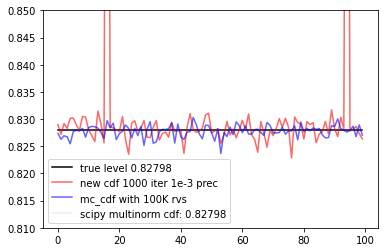

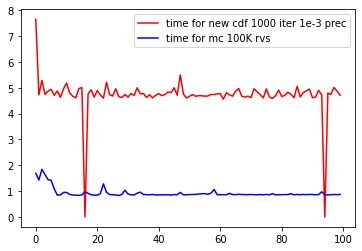

In [80]:
plt.plot([0.82798 for i in range(100)],color='black')
plt.plot([new_cdf[i][0] for i in range(100)],color='red',alpha=0.6)
plt.plot([mc_est[i][0] for i in range(100)],color='blue',alpha=0.6)
plt.plot([0.8279848479194519 for i in range(100)],alpha=0.1)
plt.ylim((0.81,0.85))
plt.legend([str('true level 0.82798'),str('new cdf 1000 iter 1e-3 prec'),str('mc_cdf with 100K rvs'),str('scipy multinorm cdf: 0.82798')])
plt.show()
plt.plot([new_cdf[i][1] for i in range(100)],color='red')
plt.plot([mc_est[i][1] for i in range(100)],color='blue')
plt.legend(['time for new cdf 1000 iter 1e-3 prec','time for mc 100K rvs'])

In [6]:
# setup for application with cov_mat
# 3 dimensional setup
covariance_matrix = np.nan_to_num(rbf(dist_mat[:1000,:1000],gamma=1/(2*0.8*0.8)),copy=False,nan=0)
a = [-np.inf for i in range(1000)]
b = inv_us[3][:1000]

new_cdf1000 = [[] for i in range(1000)]
mc_est1000 = [[] for i in range(1000)]
#scs_cdf = [[] for i in range(100)]
for i in tqdm(range(1000)):
    start = datetime.now()
    new_cdf1000[i].append(mvn_cdf(a,b,covariance_matrix)[:1])
    new_cdf1000[i].append((datetime.now()-start).total_seconds())
    rand_vars = scs.multivariate_normal.rvs(np.zeros(1000),covariance_matrix,size=100000)
    start = datetime.now()
    mc_est1000[i].append(mc_cdf(rand_vars,covariance_matrix,b))
    mc_est1000[i].append((datetime.now()-start).total_seconds())


'\nnew_cdf1000 = [[] for i in range(1000)]\nmc_est1000 = [[] for i in range(1000)]\n#scs_cdf = [[] for i in range(100)]\nfor i in tqdm(range(1000)):\n    start = datetime.now()\n    new_cdf1000[i].append(mvn_cdf(a,b,covariance_matrix)[:1])\n    new_cdf1000[i].append((datetime.now()-start).total_seconds())\n    rand_vars = scs.multivariate_normal.rvs(np.zeros(1000),covariance_matrix,size=100000)\n    start = datetime.now()\n    mc_est1000[i].append(mc_cdf(rand_vars,covariance_matrix,b))\n    mc_est1000[i].append((datetime.now()-start).total_seconds())\n'

#### For big chunks of data, new cdf is -instant and mc takes 30+s

### TODO
 - compare mvn_cdf vs MC vs scs.multivariate_norm.cdf
 - run nll with mvn_cdf
 - then, parallelise and do mle